# Deep Learning for NLP - Project

RULES:

* Do not create any additional cell

* Fill in the blanks

* All cells should be runnable (modulo trivial compatibility bugs that we'd fix)

* 4 / 20 points will be allocated to the clarity of your code

* Efficient code will have a bonus

DELIVERABLE:

* this notebook
* the predictions of the SST test set

DO NOT INCLUDE THE DATASETS IN THE DELIVERABLE..

In [1]:
%load_ext autoreload
%autoreload 2

import io
import os
import numpy as np
import scipy
import time
from pprint import pprint

%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [2]:
PATH_TO_DATA = "data/"

# 1) Monolingual (English) word embeddings 

In [3]:
class Word2vec():
    def __init__(self, fname, nmax=100000):
        self.load_wordvec(fname, nmax)
        
        self.word2id = {w: i for i, w in enumerate(self.word2vec.keys())}
        self.id2word = {v: k for k, v in self.word2id.items()}
        
        # self.embeddings was empty. needed to add list() in Python 3 because
        # values() return an iterator in Python3
        self.embeddings = np.array(list(self.word2vec.values()))
    
    def load_wordvec(self, fname, nmax):
        self.word2vec = {}
        with io.open(fname, encoding='utf-8') as f:
            next(f) # to skip the header
            i = 0
            for line in f:
                word, vec = line.split(' ', 1)
                # lower the word because in the future sentences.txt have no Maj
                # so it will work if we load only the 5000 fist word2vec....
                
                # add if condition, otherwise Cat will be overwriten
                # by cat and we will have bad results as w2v[cat] != w2v[Cat]
                if word.lower() not in self.word2vec:
                    self.word2vec[word.lower()] = np.fromstring(vec, sep=' ')
                    i += 1
                if i == nmax:
                    break
        print('Loaded %s pretrained word vectors' % (len(self.word2vec)))

    def most_similar(self, w, K=5):
        # K most similar words: self.score  -  np.argsort        
        keys = self.embeddings / np.linalg.norm(self.embeddings, 2, 1)[:, None]  # normalize embeddings
        
        idx = self.word2id[w]        
        scores = keys[idx].dot(keys.T)  # dot-product of normalized vector = cosine similarity
        
        idxs = scores.argsort()[::-1][1:K+1]
        
        # return words + similarity
        return sorted({self.id2word[idx]: "%0.3f" % (scores[idx]) for idx in idxs}.items(), key=lambda x: x[1])[::-1]

    def score(self, w1, w2):
        x, y = self.word2vec[w1], self.word2vec[w2] # get vector from dict
        return x.T.dot(y) / ( np.linalg.norm(x) * np.linalg.norm(y))

In [4]:
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=25000)

# Note: either lower word or write Paris and non paris, Germany and non germany
# ... If we lower word we will actually load 19765 vectors instead of 25000
# But I still decided to lower the word because otherwise it won't work on part 2 if
# we only load the first 5000 vectors as for example African with a Capital is not in the first 5000 words
# while african with a lowercase is in the first 5000 words, so it will work.
for w1, w2 in zip(('cat', 'dog', 'dogs', 'paris', 'germany'), ('dog', 'pet', 'cats', 'france', 'berlin')):
    print(w1, w2, w2v.score(w1, w2))

for w1 in ['cat', 'dog', 'dogs', 'paris', 'germany']: # Again need to write Paris with a P and germany with a G
    print(w1, ":", w2v.most_similar(w1))

Loaded 25000 pretrained word vectors
cat dog 0.671683666279249
dog pet 0.6842064029669219
dogs cats 0.7074389328052403
paris france 0.7058595452409974
germany berlin 0.7060253015336013
cat : [('cats', '0.835'), ('kitten', '0.802'), ('feline', '0.768'), ('kitties', '0.724'), ('dog', '0.672')]
dog : [('dogs', '0.855'), ('puppy', '0.785'), ('doggie', '0.744'), ('canine', '0.742'), ('pup', '0.740')]
dogs : [('dog', '0.855'), ('puppies', '0.714'), ('cats', '0.707'), ('canine', '0.696'), ('pets', '0.681')]
paris : [('parisian', '0.733'), ('france', '0.706'), ('marseille', '0.622'), ('louvre', '0.616'), ('versailles', '0.614')]
germany : [('austria', '0.717'), ('bavaria', '0.716'), ('berlin', '0.706'), ('munich', '0.698'), ('german', '0.683')]


In [24]:
class BoV():
    def __init__(self, w2v):
        self.w2v = w2v
    
    # output as shape (nb_sentences=150736, dim_wordembd=300)
    def encode(self, sentences, idf=False):
        sentemb = []
        
        for k, sent in enumerate(sentences):
            if idf is False:
                weighted_emb = [w2v.embeddings[w2v.word2id[w]] for w in sent.split() if w in w2v.word2id]
                if len(weighted_emb) != 0:
                    sentemb.append(np.mean(weighted_emb, axis=0))
            else:
                weighted_emb = [w2v.embeddings[w2v.word2id[w]] * idf[w] for w in sent.split() if w in w2v.word2id]

                if len(weighted_emb) != 0:
                    sentemb.append(np.sum(weighted_emb, axis=0))
        
        return np.vstack(sentemb)

    def most_similar(self, s, sentences, idf=False, K=5):
        # get most similar sentences and **print** them
        keys = self.encode(sentences, idf)
        query = self.encode([s], idf).squeeze()
        query /= np.linalg.norm(query) # not necessarily but to stay consistent and have a maximum similiraty of 1
        
        keys = keys / np.linalg.norm(keys, 2, 1)[:, None]  # normalize embeddings
        scores = query.dot(keys.T)  # dot-product of normalized vector = cosine similarity        
        idxs = scores.argsort()[::-1][1:K+1]
        
        # return sentences + similarity
        return sorted({sentences[idx]: "%0.3f" % (scores[idx]) for idx in idxs}.items(), key=lambda x: x[1])[::-1]

    def score(self, s1, s2, idf=False):
        x = self.encode([s1], idf).squeeze()
        y = self.encode([s2], idf).squeeze()
        return x.T.dot(y) / ( np.linalg.norm(x) * np.linalg.norm(y))
    
    def build_idf(self, sentences):
        # build the idf dictionary: associate each word to its idf value
        idf = {}
        for sent in sentences:
            for w in set(sent.split()):
                idf[w] = idf.get(w, 0) + 1
        
        for w in idf.keys():
            idf[w] = max(1, np.log10(len(sentences) / (idf[w])))
        
        return idf

In [25]:
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=5000)
s2v = BoV(w2v)

# Load sentences in "PATH_TO_DATA/sentences.txt"
sentences = []
with io.open(os.path.join(PATH_TO_DATA, 'sentences.txt'), encoding='utf-8') as f:
    for line in f:
        sentences.append(line.rstrip())

# Build idf scores for each word
idf = s2v.build_idf(sentences)

# You will be evaluated on the output of the following:
printmd("\n__Using mean BoV__")
print("most similar 5 sentences to: ", sentences[10])
pprint(s2v.most_similar('' if not sentences else sentences[10], sentences))  # BoV-mean

print(sentences[7] + '\n' + sentences[13])
print(s2v.score('' if not sentences else sentences[7], '' if not sentences else sentences[13]))


idf = s2v.build_idf(sentences)
printmd("\n__Using idf weighting__")
print("most similar 5 sentences to: ", sentences[10])
pprint(s2v.most_similar('' if not sentences else sentences[10], sentences, idf))  # BoV-idf

print(sentences[7] + '\n' + sentences[13])
print(s2v.score('' if not sentences else sentences[7], '' if not sentences else sentences[13], idf))

Loaded 5000 pretrained word vectors



__Using mean BoV__

most similar 5 sentences to:  1 smiling african american boy .
[('an african american man smiling .', '0.869'),
 ('african american female in a gray dress .', '0.817'),
 ('a little african american boy and girl looking up .', '0.814'),
 ('an african american man playing a saxophone .', '0.814'),
 ('an african american in sunglasses and a white tee-shirt smiles .', '0.813')]
1 man singing and 1 man playing a saxophone in a concert .
10 people venture out to go crosscountry skiing .
0.6089445116147132



__Using idf weighting__

most similar 5 sentences to:  1 smiling african american boy .
[('an african american man smiling .', '0.876'),
 ('an african american in sunglasses and a white tee-shirt smiles .', '0.860'),
 ('an african american man playing a saxophone .', '0.852'),
 ('an african american man is sitting .', '0.850'),
 ('an african american male holding a microphone .', '0.833')]
1 man singing and 1 man playing a saxophone in a concert .
10 people venture out to go crosscountry skiing .
0.5963335652885747


# 2) Multilingual (English-French) word embeddings

Let's consider a bilingual dictionary of size V_a (e.g French-English).

Let's define **X** and **Y** the **French** and **English** matrices.

They contain the embeddings associated to the words in the bilingual dictionary.

We want to find a **mapping W** that will project the source word space (e.g French) to the target word space (e.g English).

Procrustes : **W\* = argmin || W.X - Y ||  s.t  W^T.W = Id**
has a closed form solution:
**W = U.V^T  where  U.Sig.V^T = SVD(Y.X^T)**

In what follows, you are asked to: 

In [26]:
# 1 - Download and load 50k first vectors of
#     https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.en.vec
#     https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.fr.vec

from collections import OrderedDict

def load(filename):
    w2v = OrderedDict()
    with io.open(filename, encoding='utf-8') as f:
        next(f) # to skip the header
        for i, line in enumerate(f):
            if i == 50000:
                break
            word, vec = line.split(' ', 1)
            w2v[word] = np.fromstring(vec, sep=' ')
    
    return w2v

en_w2v = load(os.path.join(PATH_TO_DATA, 'wiki.en.vec'))
fr_w2v = load(os.path.join(PATH_TO_DATA, 'wiki.fr.vec'))

In [27]:
# 2 - Get words that appear in both vocabs (= identical character strings)
#     Use it to create the matrix X and Y (of aligned embeddings for these words)

sim_words = [w for w in en_w2v.keys() if w in fr_w2v]
print("nb of similar words: ", len(sim_words))

def align_embd(dico, words, word2vec_dim=300):
    X = np.zeros((word2vec_dim, len(words)))
    for i, w in enumerate(words):
        X[:,i] = dico[w]
    
    return X

# X and Y have shape (300, 18970)
X = align_embd(fr_w2v, sim_words)
Y = align_embd(en_w2v, sim_words)

nb of similar words:  18970


In [28]:
# 3 - Solve the Procrustes using the scipy package and: scipy.linalg.svd() and get the optimal W
#     Now W*French_vector is in the same space as English_vector
import scipy.linalg as la

U, S, Vh = la.svd(Y.dot(X.T), full_matrices=True)
W = U.dot(Vh)

In [29]:
# 4 - After alignment with W, give examples of English nearest neighbors of some French words (and vice versa)
#     You will be evaluated on that part and the code above

# change idx to find closet words of any other word
fr_idx = 150
en_idx = 47

# french word in the same space as english word
Y_fr = W.dot(X)

def k_crosslanguage_nearest_neighbors(y1, Y2, dico, K=5):
    """
        Args:
            y1 (1d-array): word embedding (for example Y_fr[1])
            Y2 (2d-array): matrix of word embeddings in another language (Y_en)
            dico (dict): dictionary that maps words idx in Y2 to word
        Return:
            K nearest words to y1 in Y2
    """
    word_emb = y1 / np.linalg.norm(y1) # normalize word embedding
    
    # normalize embeddings matrix
    word_mat = Y2 / np.linalg.norm(Y2, 2, 1)[:, None]
    
    # dot-product of normalized vector = cosine similarity
    scores = word_emb.dot(word_mat.T)
    
    # get K closest neighbors (avoid itself: add 1 to K)
    idxs = scores.argsort()[::-1][1:K+1]
        
    # return sentences + similarity
    return [(dico[idx], scores[idx]) for idx in idxs]


dico = {i: w for i, w in enumerate(sim_words)}
print("5 closest english words to the french word: ", dico[fr_idx])
pprint(k_crosslanguage_nearest_neighbors(Y_fr.T[fr_idx], Y.T, dico))

print("5 closest french words to the english word: ", dico[en_idx])
pprint(k_crosslanguage_nearest_neighbors(Y.T[en_idx], Y_fr.T, dico))

5 closest english words to the french word:  november
[('november', 0.5261849522367746),
 ('june', 0.5253903375946429),
 ('october', 0.5235082151727514),
 ('december', 0.5180903659887707),
 ('february', 0.5178299454693243)]
5 closest french words to the english word:  first
[('first', 0.5813927538751525),
 ('premier', 0.5811306278512199),
 ('third', 0.5001826433709174),
 ('person', 0.4654406466211093),
 ('second', 0.4442531059393303)]


If you want to dive deeper on this subject: https://github.com/facebookresearch/MUSE

# 3) Sentence classification with BoV and scikit-learn

In [7]:
# 1 - Load train/dev/test of Stanford Sentiment TreeBank (SST)
#     (https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf)

PATH_TO_SST = 'data/SST/'

def load_tb(filename, test=False):
    sentences = []
    labels = []
    with io.open(filename, encoding='utf-8') as f:
        for line in f:
            if not test:
                label, line = line.split(' ', 1)
                labels.append(label)
            sentences.append(line.rstrip())
    
    return sentences, labels

sst_test, _ = load_tb(os.path.join(PATH_TO_SST, 'stsa.fine.test.X'), True)
sst_dev, sst_dev_label = load_tb(os.path.join(PATH_TO_SST, 'stsa.fine.dev'))
sst_train, sst_train_label = load_tb(os.path.join(PATH_TO_SST, 'stsa.fine.train'))

In [ ]:
# 2 - Encode sentences with the BoV model above

# load word2vec with all the words
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=200000)
s2v = BoV(w2v)

activate_idf = False # set True to use idf

# NOTE: be sure to have set nmax=200000 when creating the word2vec embeddings
idf = False if activate_idf is False else s2v.build_idf(sst_test)
sst_test_emb = s2v.encode(sst_test, idf=idf)

idf = False if activate_idf is False else s2v.build_idf(sst_dev)
sst_dev_emb = s2v.encode(sst_dev, idf=idf)

idf = False if activate_idf is False else s2v.build_idf(sst_train)
sst_train_emb = s2v.encode(sst_train, idf=idf)

In [ ]:
# 3 - Learn Logistic Regression on top of sentence embeddings using scikit-learn
#     (consider tuning the L2 regularization on the dev set)

# best values found using C value in Cs = np.logspace(-3, 3, 100)
# mean: 0.447 1.417
# idf: 0.4159 C = 0.001

from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(solver='sag', C=1.41, n_jobs=-1)

logreg.fit(sst_train_emb, sst_train_label)
predictions = logreg.predict(sst_dev_emb)

# print accuracy on the dev set (we have the ground truth)
score_train = logreg.score(sst_train_emb, sst_train_label)
score = logreg.score(sst_dev_emb, sst_dev_label)

print("accuracy on training set: ", score_train)
print("accuracy on dev set: ", score)

In [16]:
# 4 - Produce 2210 predictions for the test set (in the same order). One line = one prediction (=0,1,2,3,4).
#     Attach the output file "logreg_bov_y_test_sst.txt" to your deliverable.
#     You will be evaluated on the results of the test set.

predicted_label = logreg.predict(sst_test_emb)

with io.open('logreg_bov_y_test_sst.txt', 'w') as f:
    for e in predicted_label:
        f.write("%s\n" % e)

In [17]:
# BONUS!
# 5 - Try to improve performance with another classifier
#     Attach the output file "XXX_bov_y_test_sst.txt" to your deliverable (where XXX = the name of the classifier)
import xgboost as xgb

# use DMatrix for xgboost
dtrain = xgb.DMatrix(sst_train_emb, label=sst_train_label)
dtest = xgb.DMatrix(sst_dev_emb, label=sst_dev_label)


param = {
    'booster': 'dart',
    'max_depth': 6,  # the maximum depth of each tree
    'eta': 0.3,  # the training step for each iteration
    'silent': 1,  # logging mode - quiet
    'objective': 'multi:softprob',  # error evaluation for multiclass training
    'num_class': 5, # the number of classes that exist in this datset
    'tree_method': 'gpu_hist',
    'lambda': 2,
    'alpha': 2,
    'eval_metric': 'mlogloss'
}  

num_round = 20  # the number of training iterations

bst = xgb.train(param, dtrain, num_round)

trains = bst.predict(dtrain)
preds = bst.predict(dtest)

train_acc = len(np.where(np.argmax(trains, axis=1) == np.array(sst_train_label, dtype=np.int))[0]) / len(sst_train_label)
test_acc = len(np.where(np.argmax(preds, axis=1) == np.array(sst_dev_label, dtype=np.int))[0]) / len(sst_dev_label)

print("accuracy on training set: ", train_acc)
print("accuracy on dev set: ", test_acc)

KeyboardInterrupt: 

# 4) Sentence classification with LSTMs in Keras

## 4.1 - Preprocessing

In [5]:
import keras

C:\Anaconda3\envs\aind-dog\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [8]:
# 1 - Load train/dev/test sets of SST
PATH_TO_SST = 'data/SST/'

sst_test, _ = load_tb(os.path.join(PATH_TO_SST, 'stsa.fine.test.X'), True)
sst_dev, sst_dev_label = load_tb(os.path.join(PATH_TO_SST, 'stsa.fine.dev'))
sst_train, sst_train_label = load_tb(os.path.join(PATH_TO_SST, 'stsa.fine.train'))

In [9]:
# 2 - Transform text to integers using keras.preprocessing.text.one_hot function
#     https://keras.io/preprocessing/text/

from keras.preprocessing.text import text_to_word_sequence, one_hot

def get_vocsize(*args):
    r = []
    
    for a in args:
        for e in a:
            words = text_to_word_sequence(e)
            for w in words:
                r.append(w)
            
    return len(list(set(r)))


def text_to_num(n, *args):
    r = []
    
    for a in args:
        data = []
        for e in a:
            data.append(one_hot(e, n))
        
        r.append(data)
    
    return np.array(r[0]), np.array(r[1]), np.array(r[2])

n = get_vocsize(sst_test, sst_dev, sst_train)
X_train, X_dev, X_test = text_to_num(n, sst_train, sst_dev, sst_test)

**Padding input data**

Models in Keras (and elsewhere) take batches of sentences of the same length as input. It is because Deep Learning framework have been designed to handle well Tensors, which are particularly suited for fast computation on the GPU.

Since sentences have different sizes, we "pad" them. That is, we add dummy "padding" tokens so that they all have the same length.

The input to a Keras model thus has this size : (batchsize, maxseqlen) where maxseqlen is the maximum length of a sentence in the batch.

In [19]:
# 3 - Pad your sequences using keras.preprocessing.sequence.pad_sequences
#     https://keras.io/preprocessing/sequence/

from keras.preprocessing.sequence import pad_sequences

X_train = pad_sequences(X_train)
X_dev = pad_sequences(X_dev)
X_test = pad_sequences(X_test)

## 4.2 - Design and train your model

In [58]:
# 4 - Design your encoder + classifier using keras.layers
#     In Keras, Torch and other deep learning framework, we create a "container" which is the Sequential() module.
#     Then we add components to this contained : the lookuptable, the LSTM, the classifier etc.
#     All of these components are contained in the Sequential() and are trained together.

from keras.models import Sequential
from keras import regularizers
from keras.layers import *

embed_dim  = 64  # word embedding dimension
nhid       = 32  # number of hidden units in the LSTM
vocab_size = n  # size of the vocabulary
n_classes  = 5

model = Sequential()
model.add(Embedding(vocab_size, embed_dim))
model.add(LSTM(nhid, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(n_classes, activation='softmax'))

In [59]:
# 5 - Define your loss/optimizer/metrics

from keras import optimizers
from keras import metrics

loss_classif     =  'categorical_crossentropy' # find the right loss for multi-class classification
optimizer        =  'adam' # find the right optimizer
metrics_classif  =  ['accuracy']

# Observe how easy (but blackboxed) this is in Keras
model.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_20 (Embedding)     (None, None, 64)          1141696   
_________________________________________________________________
lstm_37 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dropout_37 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_28 (Dense)             (None, 5)                 165       
Total params: 1,154,277
Trainable params: 1,154,277
Non-trainable params: 0
_________________________________________________________________
None


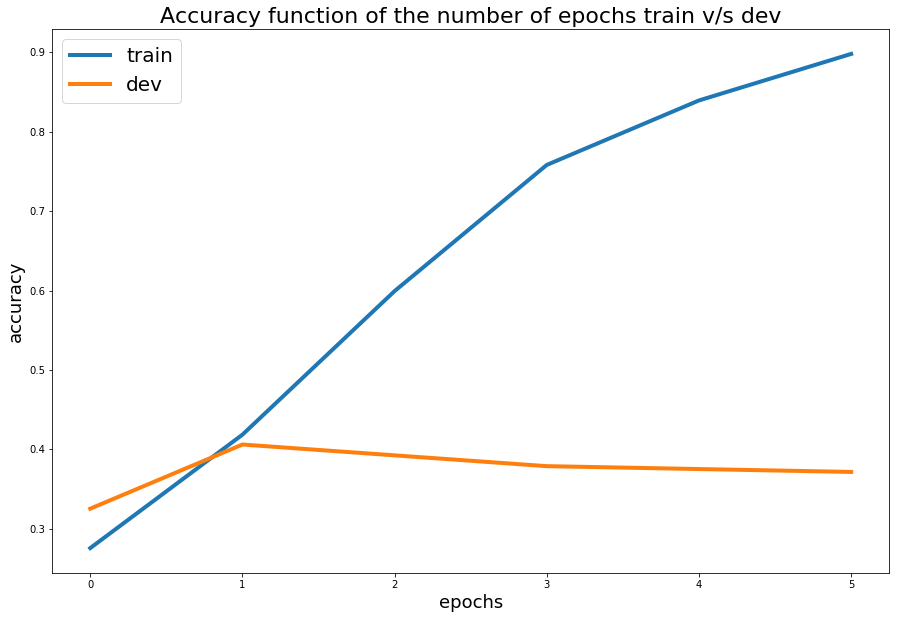

In [60]:
# 6 - Train your model and find the best hyperparameters for your dev set
#     you will be evaluated on the quality of your predictions on the test set

from keras.utils import to_categorical
from keras_tqdm import TQDMNotebookCallback

bs = 64
n_epochs = 6

y_train = to_categorical(np.array(sst_train_label).astype(int))
y_dev = to_categorical(np.array(sst_dev_label).astype(int))

class SaveEpoch(keras.callbacks.Callback):
    def __init__(self):
        self.test_epoch = []
        self.train_epoch = []

    def on_epoch_end(self, epoch, logs={}):
        self.test_epoch.append(logs.get('val_acc'))
        self.train_epoch.append(logs.get('acc'))
        return

histories = SaveEpoch()
    
model.fit(X_train, y_train, batch_size=bs,
          validation_data=(X_dev, y_dev),
          epochs=n_epochs, callbacks=[histories, TQDMNotebookCallback(leave_inner=True, leave_outer=True)], verbose=0)

plt.figure(figsize=(15,10))
plt.title('Accuracy function of the number of epochs train v/s dev', fontsize=22)
plt.plot(histories.train_epoch, label='train', linewidth=4.0)
plt.plot(histories.test_epoch, label='dev', linewidth=4.0)
plt.xlabel('epochs', fontsize=18)
plt.ylabel('accuracy', fontsize=18)
plt.legend(prop={'size': 20})

In [61]:
# 7 - Generate your predictions on the test set using model.predict(x_test)
#     https://keras.io/models/model/
#     Log your predictions in a file (one line = one integer: 0,1,2,3,4)
#     Attach the output file "logreg_lstm_y_test_sst.txt" to your deliverable.

predicted_label = model.predict(X_test)

with io.open('logreg_lstm_y_test_sst.txt', 'w') as f:
    for e in predicted_label:
        f.write("%s\n" % e)

## 4.3 -- innovate !

In [62]:
# 8 - Open question: find a model that is better on your dev set
#     (e.g: use a 1D ConvNet, use a better classifier, pretrain your lookup tables ..)
#     you will get point if the results on the test set are better: be careful of not overfitting your dev set too much..
#     Attach the output file "XXX_XXX_y_test_sst.txt" to your deliverable.
from collections import OrderedDict

def get_voc(*args):
    """
        Args:
            *args (lists of strings): list of the strings of the training/dev/testing dataset
        Returns:
            list: a list containing all the words (unique)
    """
    r = []
    
    for a in args:
        for e in a:
            words = text_to_word_sequence(e)
            for w in words:
                r.append(w)
                
    uniq_word = list(set(r)) # set use to discard duplicates
    
    return {w: None for w in uniq_word}

def word_to_embeddings(filename, *args):
    voca = get_voc(*args)
    w2e = OrderedDict()
    
    max_size = len(voca)
    counter = 0
    with io.open(filename, encoding='utf-8') as f:
        next(f) # to skip the header
        for line in f:
            if counter == max_size:
                break
            word, vec = line.split(' ', 1)
            if word.strip().lower() in voca:
                w2e[word] = np.fromstring(vec, sep=' ')
                counter += 1
    
    return w2e

def getEmbeddings(voc_list):
    """
        Args:
            voc_list (list): list of unique words extracted from all questions
        Returns:
            embeddings (ndarray): A matrix of shape (vocabulary size, embeddings_size)
    """
    embeddings = np.zeros((len(voc_list), 300))
    for i, w in enumerate(voc_list):
        embeddings[i] = word_embeddings(w).vector

    return embeddings

# take 20 seconds on my computer...
w2v_dict = word_to_embeddings(os.path.join(PATH_TO_DATA, 'wiki.en.vec'), sst_test, sst_dev, sst_train)

In [63]:
vocabulaire = set(get_voc(sst_test, sst_dev, sst_train)) # voc from the SST files
voca_w2v = set(w2v_dict.keys()) # voc using word_2_vec from wikipedia

In [64]:
vocabulaire.difference(voca_w2v) # difference: some words in the SST dataset are not in the w2v file from wikipedia....

{"''",
 "'30s",
 "'40s",
 "'50s",
 "'53",
 "'60s",
 "'70s",
 "'80s",
 "'90s",
 "'d",
 "'em",
 "'ll",
 "'m",
 "'n",
 "'n'",
 "'re",
 "'s",
 "'til",
 "'ve",
 '00',
 '000',
 '007',
 '1',
 '10',
 '100',
 '101',
 '102',
 '103',
 '104',
 '105',
 '10th',
 '11',
 '110',
 '112',
 '117',
 '11th',
 '12',
 '120',
 '123',
 '125',
 '127',
 '129',
 '12th',
 '13',
 '13th',
 '14',
 '140',
 '146',
 '15',
 '15th',
 '16',
 '163',
 '168',
 '17',
 '170',
 '179',
 '1790',
 '18',
 '180',
 '1873',
 '1899',
 '18th',
 '19',
 '1915',
 '1920',
 '1930s',
 '1933',
 '1934',
 '1937',
 '1938',
 '1940s',
 '1949',
 '1950',
 '1950s',
 '1952',
 '1953',
 '1954',
 '1955',
 '1957',
 '1958',
 '1959',
 '1960',
 '1960s',
 '1962',
 '1967',
 '1970',
 '1970s',
 '1971',
 '1972',
 '1973',
 '1975',
 '1978',
 '1979',
 '1980',
 '1980s',
 '1982',
 '1983',
 '1984',
 '1986',
 '1987',
 '1988',
 '1989',
 '1990',
 '1991',
 '1992',
 '1993',
 '1994',
 '1995',
 '1997',
 '1998',
 '1999',
 '19th',
 '2',
 '20',
 '2000',
 '2001',
 '2002',
 '20th',
 

As there are some words that aren't in the wikipedia word2vec embeddings file. We will use a nlp library called __spacy__ to create the word_2_vec embeddings. It the word is not in the w2v embedding from spacy it will output a matrix full of 0. So at least we will have the same number of vectors in our embedding matrix created using __spacy__. Also for the number like 101 and so on... __spacy__ word2vec actually outputs a non-zero matrix. So this is why we will work with __spacy__.

In [65]:
import spacy
word_embeddings = spacy.load('en_vectors_web_lg')

In [66]:
word_embeddings("007").vector

array([-1.8077e-01, -5.0062e-01,  7.9536e-01, -5.2051e-02,  5.0713e-01,
       -5.8448e-01,  3.2312e-01, -1.4564e-01,  2.7792e-01, -5.3547e-01,
       -4.3922e-01, -3.1055e-01, -1.4749e-01, -6.0710e-01,  6.6245e-01,
        8.5843e-02,  1.7011e-02,  4.4511e-01, -1.8620e-01, -3.4050e-01,
       -2.3033e-01, -4.7385e-01, -5.4631e-04, -2.8088e-02,  9.9480e-02,
        3.7621e-01,  1.4162e-01, -2.2744e-01, -5.2226e-01, -4.3033e-01,
       -2.3946e-01,  3.6224e-02, -1.9986e-02,  3.5777e-01, -1.5170e-01,
        3.5257e-01,  7.8492e-01, -2.2333e-01,  3.3794e-01,  9.3280e-02,
        5.5150e-01, -4.4073e-01,  3.5081e-01, -1.7353e-01, -1.7417e-01,
        4.4464e-01,  3.9337e-02, -1.0676e-02, -8.2481e-02, -1.0295e-01,
        4.2537e-01, -3.6940e-01, -2.7055e-01,  6.0478e-02,  3.3227e-02,
        1.9404e-01,  1.8010e-01, -5.3708e-01,  6.3014e-01,  1.0596e-01,
        3.4091e-01, -1.1620e-01,  2.0526e-02,  2.7498e-01, -5.2033e-01,
        4.2709e-01, -8.7570e-02, -1.7318e-01,  6.6776e-03, -4.41

In [67]:
word_embeddings("destinees").vector

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [68]:
# get vocabulary
def getEmbeddings(voc_list):
    """
        Args:
            voc_list (list): list of unique words extracted from all questions
        Returns:
            embeddings (ndarray): A matrix of shape (vocabulary size, embeddings_size)

    """
    embeddings = np.zeros((len(voc_list), 300))
    for i, w in enumerate(voc_list):
        embeddings[i] = word_embeddings(w).vector

    return embeddings

vocab = list(get_voc(sst_test, sst_dev, sst_train))
embedding_matrix = getEmbeddings(vocab)

# need to transform X_test, X_train, X_dev into matrix of idx of word in embedding_matrix
def preprocess_matrix(X, vocab, max_len):
    vocab = {k: i for i, k in enumerate(vocab)}
    new_X = np.zeros((len(X), max_len), dtype=int)
    
    for i, e in enumerate(X):
        w_list = text_to_word_sequence(e)
        size = len(w_list)
        for j, w in enumerate(w_list):
            new_X[i,max_len-size+j] = vocab[w]
            
    return new_X

# sst_test, sst_dev, sst_train
new_X_test = preprocess_matrix(sst_test, vocab, max_len=52)
new_X_train = preprocess_matrix(sst_train, vocab, max_len=52)
new_X_dev = preprocess_matrix(sst_dev, vocab, max_len=52)

In [71]:
from keras.models import *
from keras.layers import merge
from keras.layers.core import *

voc_size = embedding_matrix.shape[0]
word2vec_dim = embedding_matrix.shape[1]
max_len = 52 # this is the maximum number of word in a string (it appears in X_text, just do X_test.shape)
activation = 'tanh'
q_hidden_units = 64
merge_hidden_units = 50


_input = Input(shape=[max_len], dtype='int32')

# get the embedding layer
embedded = Embedding(
        input_dim=voc_size,
        output_dim=word2vec_dim,
        weights=[embedding_matrix],
        input_length=max_len,
        trainable=False,
        mask_zero=False
    )(_input)

lstm = LSTM(q_hidden_units, return_sequences=False)(embedded)
probabilities = Dense(5, activation='softmax')(lstm)
better_model = Model(input=[_input], output=probabilities)
better_model.compile(loss='categorical_crossentropy', optimizer='adam',  metrics=['accuracy'])
better_model.summary()

C:\Anaconda3\envs\aind-dog\lib\site-packages\ipykernel\__main__.py:27: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 52)                0         
_________________________________________________________________
embedding_23 (Embedding)     (None, 52, 300)           5351700   
_________________________________________________________________
lstm_40 (LSTM)               (None, 64)                93440     
_________________________________________________________________
dense_30 (Dense)             (None, 5)                 325       
Total params: 5,445,465
Trainable params: 93,765
Non-trainable params: 5,351,700
_________________________________________________________________


Exception in thread Thread-10:
Traceback (most recent call last):
  File "C:\Anaconda3\envs\aind-dog\lib\threading.py", line 914, in _bootstrap_inner
    self.run()
  File "C:\Anaconda3\envs\aind-dog\lib\site-packages\tqdm\_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "C:\Anaconda3\envs\aind-dog\lib\_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



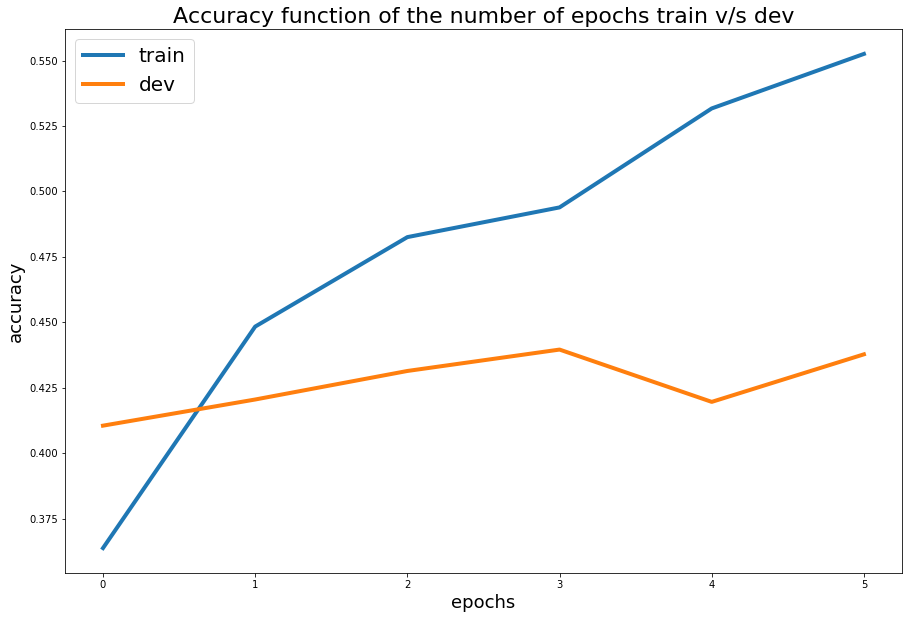

In [72]:
histories2 = SaveEpoch()

better_model.fit(new_X_train, y_train, batch_size=bs,
          validation_data=(new_X_dev, y_dev),
          epochs=n_epochs, callbacks=[histories2, TQDMNotebookCallback(leave_inner=True, leave_outer=True)], verbose=0)

plt.figure(figsize=(15,10))
plt.title('Accuracy function of the number of epochs train v/s dev', fontsize=22)
plt.plot(histories2.train_epoch, label='train', linewidth=4.0)
plt.plot(histories2.test_epoch, label='dev', linewidth=4.0)
plt.xlabel('epochs', fontsize=18)
plt.ylabel('accuracy', fontsize=18)
plt.legend(prop={'size': 20})